# Mosaic Indices

<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/Indices%20-%20composite.png" />

[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)

This product generates mosaics using Indices (NDVI, EVI, NDWI, NDDI). 


In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob

# Import functions to load and stack data without datacube
from notebook_functions import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43989/status,
Dashboard: http://127.0.0.1:43989/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45643,Workers: 2
Dashboard: http://127.0.0.1:43989/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:42775,Total threads: 4
Dashboard: http://127.0.0.1:34573/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:33257,


## Set Up Parameters

In [3]:
# Running locally on landsat 8 data for now
product = 'landsat_8'

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

# Set mosaic type (options: 'median', 'mean', 'max', 'min')
mosaic_type = 'median'

# Set the desired index (options: 'EVI', 'NDVI', 'NDDI', NDWI_Green', 'NDWI_SWIR')
indices = 'NDVI'

# Select the relevant bands depending on the index
def relevantBands(indices):
    if indices == 'NDVI':
        ISMeasurements = ['red', 'swir1']
    if indices == 'NDWI_Green':
        ISMeasurements = ['green', 'red']
    if indices == 'NDWI_SWIR':
        ISMeasurements = ['green', 'red','swir1']
    if indices == 'NDDI':
        ISMeasurements = ['red', 'green', 'swir1']
    if indices == 'EVI':
        ISMeasurements = ['red', 'blue']
    return(ISMeasurements)

measurements = relevantBands(indices)  

# Add either the pixel_qa or the scene_classification band to the list of measurements
if product  in ["sentinel_2"]:
    measurements = measurements + ["nir08", "scene_classification"]
elif product.startswith('landsat_'):    
    measurements = measurements + ["nir", "pixel_qa"]
else:
    print("invalid product")

## Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Running on data from St Maarten
dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat/'
ds = prep_dataset(dir, measurements, product, clip_coords)

## Run data for Tile7572 
# dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/BaselineData/'
# ds = prep_dataset(dir, allmeasurements, product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 7, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2022-11-20 ... 2018-03-14
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          -9999


## Cloud Masking

In [6]:
# Use the landsat clean mask function to mask out clouds and water.
clean_mask = ls_clean_mask(ds, keep_water=False)

## Create Composites

In [7]:
def create_temporal_composite(dataset, mosaic_type, clean_mask=None):
    if clean_mask is not None:
        dataset = dataset.where(clean_mask == 1, np.nan)
    
    # Select and run the mosaic type
    if mosaic_type in ['mean']:
        composite = dataset.mean(dim=['time'])
    elif mosaic_type in ['max']:
        composite = dataset.max(dim=['time'])
    elif mosaic_type in ['min']:
        composite = dataset.min(dim=['time'])
    elif mosaic_type in ['median']:
        composite = dataset.median(dim=['time'])
    else:
        print('invalid mosaic')
    
    return composite

# Create composites (summarizing through time) of the baseline and analysis datasets
ds_composite = create_temporal_composite(ds, mosaic_type, clean_mask = clean_mask)

## Calculate Indices

In [8]:
# Correct NDVI bands
def NDVI(dataset):
    NDVI = (dataset.nir - dataset.red)/(dataset.nir + dataset.red)
    NDVI = NDVI.where(dataset.nir.notnull() & dataset.red.notnull())
    return NDVI

def EVI(dataset):
    #ds = dataset / 10000 # Bands need to be scaled between 0 and 1
    
    C1 = 6
    C2 = 7.5
    L = 1
    return 2.5 * ((dataset.nir - dataset.red) / (dataset.nir + (C1 * dataset.red) - (C2 * dataset.blue) + L))

def NDWI_Green(dataset):
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

def NDWI_SWIR(dataset):
    return (dataset.green - dataset.swir16)/(dataset.green + dataset.swir16)

def NDDI(dataset):
    aNDVI = NDVI(dataset)
    aNDWI = NDWI_SWIR(dataset)
    return (aNDVI - aNDWI)/(aNDVI + aNDWI)

In [9]:
indices_function = {"NDVI": NDVI, "NDWI_Green": NDWI_Green, "NDWI_SWIR": NDWI_SWIR, "EVI": EVI, "NDDI": NDDI}
indices_compositor = indices_function[indices]
indices_composite = indices_compositor(ds_composite)
print(indices_composite)

<xarray.DataArray (y: 1429, x: 2455)>
dask.array<where, shape=(1429, 2455), dtype=float32, chunksize=(1429, 2455), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95


### Visualize Indices

/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


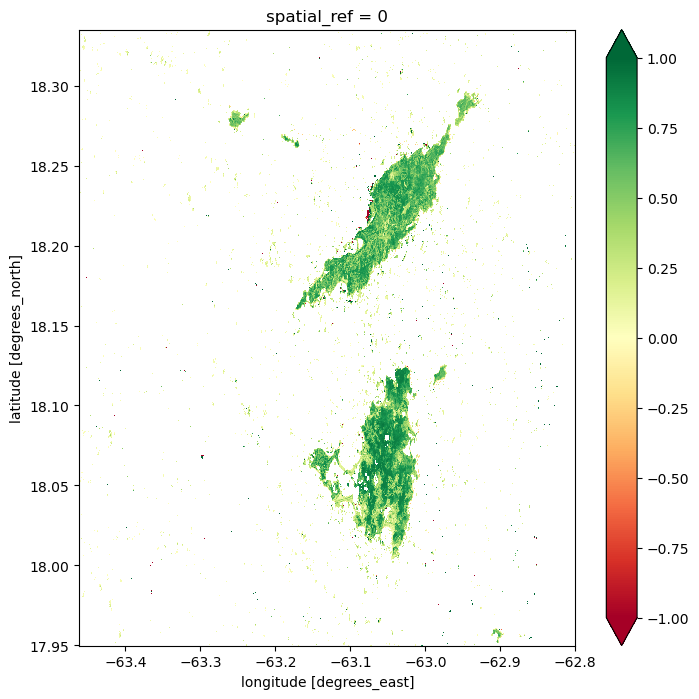

In [10]:
# Viz Bounding Box
viz_coords = {'min_lon':-63.15,
               'min_lat': 18.0,
               'max_lon': -63.0,
               'max_lat': 18.1}

subset_indices_composite = indices_composite.rio.clip_box(minx = viz_coords['min_lon'], miny = viz_coords['min_lat'], 
                                                maxx = viz_coords['max_lon'], maxy = viz_coords['max_lat']) 

plt.figure(figsize = (8,8))
if indices in ["NDVI"]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = 'RdYlGn')
elif indices in ["NDWI_Green"]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = 'RdYlGn')
elif indices in ["EVI"]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = 'RdYlGn')
elif indices in ["NDDI"]:
    indices_composite.plot(vmin=-30, vmax=30, cmap = 'RdYlGn')
else:
    print('indicies invalid')

## Export Desired Data

In [11]:
#indices_composite.rio.to_raster(f"StMaarten_NDVIMosaic.tif", dtype="float32", driver='COG')